In [ ]:
# --- Imports and Setup ---
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, SystemMessage
from langgraph.as_tool import Tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_groq.chat_models import ChatGroq
from langchain_core.tools import tool
from youtube_transcript_api import YouTubeTranscriptApi
import re
import os
from dotenv import load_dotenv

load_dotenv()

True

In [20]:
# --- Tool: YouTube Transcript Fetcher ---
@tool
def get_transcript(url: str) -> str:
    """Fetch the transcript from a YouTube video URL."""
    # Extract video ID
    regex = r"(?:youtube\.com\/(?:[^\/]+\/.+\/|(?:v|e(?:mbed)?)\/|.*[?&]v=)|youtu\.be\/|youtube\.com\/shorts\/)([^\"&?\/\s]{11})"
    match = re.search(regex, url)
    if not match:
        return "Invalid YouTube URL."
    video_id = match.group(1)
    # Fetch transcript
    try:
        transcript_raw = YouTubeTranscriptApi.get_transcript(video_id, languages=['en'])
        transcript = " ".join([seg['text'] for seg in transcript_raw])
        return transcript
    except Exception as e:
        return f"Unfortunately, the transcript could not be fetched due to the YouTube API limitations. ({e})"

tools = [get_transcript]

In [21]:
# --- State Definition ---
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

# --- LLM Setup with Blog Prompt ---
system_prompt = (
    "You are a professional blog writer. "
    "Given a transcript of a YouTube video, write a detailed, engaging blog post summarizing and expanding on the content. "
    "If you do not have the transcript, first use the `get_transcript` tool to fetch it."
)
llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools)

In [26]:

# --- Nodes ---
def call_model(state: AgentState, config=None):
    # Always prepend the system prompt
    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    response = llm_with_tools.invoke(messages, config)
    return {"messages": [response]}

def tool_node(state: AgentState):
    # Find the last tool call in the messages
    from langchain_core.messages import ToolMessage
    outputs = []
    last_message = state["messages"][-1]
    for tool_call in getattr(last_message, "tool_calls", []):
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_result = [t for t in tools if t.name == tool_name][0].invoke(tool_args)
        outputs.append(ToolMessage(content=str(tool_result), name=tool_name, tool_call_id=tool_call["id"]))
    return {"messages": outputs}


In [27]:
# --- Graph Construction ---
graph_builder = StateGraph(AgentState)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("agent", call_model)

# Define the edges for the desired flow
graph_builder.add_edge(START, "tools")      # Start to tools
graph_builder.add_edge("tools", "agent")    # tools to agent
graph_builder.add_edge("agent", END)        # agent to END

graph = graph_builder.compile()


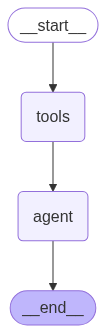

In [28]:
# ---Graph Image ---
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
from langchain_core.messages import HumanMessage

def generate_blog_from_youtube(url: str):
    # Start with a HumanMessage containing the URL
    state = {"messages": [HumanMessage(content=url)]}
    result = graph.invoke(state)
    # The final message is the blog post
    blog_post = result["messages"][-1].content
    return blog_post

# Example usage:
if __name__ == "__main__":
    youtube_url = "https://youtu.be/-UQ6OZywZ2I?feature=shared"
    blog = generate_blog_from_youtube(youtube_url)
    print(blog)